# Week 2 Assignment

## Dataset
In this homework, we will use the New York City Airbnb Open Data. You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv) or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv) if you don't want to sign up to Kaggle.

The goal of this homework is to create a regression model for prediction apartment prices (column `'price'`).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import wget
wget.download('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv')

100% [..........................................................................] 7077973 / 7077973

'AB_NYC_2019.csv'

In [3]:
data = pd.read_csv('data/AB_NYC_2019.csv')

## EDA
* Load the data.
* Look at the `price` variable. Does it have a long tail?

<AxesSubplot:xlabel='price', ylabel='Count'>

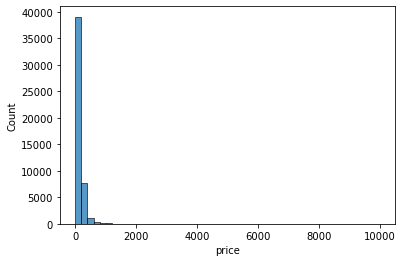

In [4]:
sns.histplot(data.price, bins=50)

## Features
For the rest of the homework, you'll need to use only these columns:

* `'latitude'`,
* `'longitude'`,
* `'price'`,
* `'minimum_nights'`,
* `'number_of_reviews'`,
* `'reviews_per_month'`,
* `'calculated_host_listings_count'`,
* `'availability_365'`

Select only them.

In [5]:
features = ['latitude', 'longitude', 'price', 'minimum_nights', 
            'number_of_reviews', 'reviews_per_month', 
            'calculated_host_listings_count', 'availability_365']

df = data[features]
df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355
2,40.80902,-73.94190,150,3,0,NaN,1,365
3,40.68514,-73.95976,89,1,270,4.64,1,194
4,40.79851,-73.94399,80,10,9,0.10,1,0


## Question 1
Find a feature with missing values. How many missing values does it have?

In [6]:
df.isna().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

## Question 2
What's the median (50% percentile) for variable 'minimum_nights'?

In [7]:
df.minimum_nights.median()

3.0

## Split the data
* Shuffle the initial dataset, use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Make sure that the target value ('price') is not in your dataframe.
* Apply the log transformation to the price variable using the `np.log1p()` function.

In [8]:
np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [9]:
y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

## Question 3
* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

In [10]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [11]:
check = ['latitude','longitude','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']

def prepare_X(df, fillna_value):
    df_num = df[check]
    df_num = df_num.fillna(fillna_value)
    X = df_num.values
    return X

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [12]:
# Fill with mean
mean = df_train.reviews_per_month.mean()

X_mean_train = prepare_X(df_train, fillna_value=mean)
w_0_mean, w_mean = train_linear_regression(X_mean_train, y_train)

X_mean_val = prepare_X(df_val, fillna_value=mean)
y_mean_pred_val = w_0_mean + X_mean_val.dot(w_mean)


np.round(rmse(y_val, y_mean_pred_val),2)

0.64

In [13]:
# Fill with zero

X_null_train = prepare_X(df_train, fillna_value=0)
w_0_null, w_null = train_linear_regression(X_null_train, y_train)


X_null_val = prepare_X(df_val, fillna_value=0)
y_null_pred_val = w_0_null + X_null_val.dot(w_null)

np.round(rmse(y_val, y_null_pred_val),2)

0.64

## Question 4
* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0.
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest r.

In [14]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [15]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_null_train, y_train, r=r)
    y_null_reg_val = w_0 + X_null_val.dot(w)
    rmse_val = np.round(rmse(y_val, y_null_reg_val),2)
    print(r, w_0, rmse_val)

0 -419.91266027829585 0.64
1e-06 -419.86271750180987 0.64
0.0001 -414.9764942018561 0.64
0.001 -375.2736539367923 0.64
0.01 -191.7838409125544 0.66
0.1 -32.56256056402254 0.68
1 -3.499216840082123 0.68
5 -0.7033623161458145 0.68
10 -0.35127675971367134 0.68


## Question 5
* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

> Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

In [16]:
rmse_list = []

for r in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

    idx = np.arange(n)
    np.random.seed(r)
    np.random.shuffle(idx)

    df_shuffled = data.iloc[idx]
    
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train_orig = df_train.price.values
    y_val_orig = df_val.price.values
    y_test_orig = df_test.price.values

    y_train = np.log1p(y_train_orig)
    y_val = np.log1p(y_val_orig)
    y_test = np.log1p(y_test_orig)
    
    del df_train['price']
    del df_val['price']
    del df_test['price']
    
    X_null_train = prepare_X(df_train, fillna_value=0)
    w_0, w = train_linear_regression(X_null_train, y_train)
    
    X_null_val = prepare_X(df_val, fillna_value=0)
    y_null_reg_val = w_0 + X_null_val.dot(w)
    rmse_val = np.round(rmse(y_val, y_null_reg_val),2)
    
    rmse_list.append(rmse_val)
    
    print(r, w_0, rmse_val)

0 -427.62844648155647 0.65
1 -414.70555038373544 0.65
2 -423.2541335359743 0.65
3 -421.8933165085607 0.64
4 -422.06098983271306 0.64
5 -429.17875171360004 0.63
6 -427.4918966200901 0.63
7 -428.188469236398 0.65
8 -427.6929091551991 0.65
9 -426.98269168475446 0.64


In [17]:
rmse_list

[0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.63, 0.65, 0.65, 0.64]

In [18]:
np.round(np.std(rmse_list),3)

0.008

## Question 6
* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`.
* What's the RMSE on the test dataset?

In [19]:
seed = 9

idx = np.arange(n)
np.random.seed(seed)
np.random.shuffle(idx)

df_shuffled = data.iloc[idx]
    
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

frames = [df_train, df_val]
df_train_val = pd.concat(frames)

df_train_val = df_train_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_val_orig = df_train_val.price.values
y_test_orig = df_test.price.values

y_train_val = np.log1p(y_train_val_orig)
y_test = np.log1p(y_test_orig)

del df_train_val['price']
del df_test['price']

In [20]:
X_null_train_val = prepare_X(df_train_val, fillna_value=0)
w_0_train_val, w_train_val = train_linear_regression_reg(X_null_train_val, y_train_val, r=0.001)

X_null_test = prepare_X(df_test, fillna_value=0)
y_null_pred_test = w_0_train_val + X_null_test.dot(w_train_val)

np.round(rmse(y_test, y_null_pred_test),2)

0.65